## Importing the required libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
#from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [2]:
from keras import regularizers

In [3]:
import os

In [4]:
mylist= os.listdir('RawData/')

In [5]:
type(mylist)

list

In [6]:
print(mylist[59])

03-01-08-02-02-02-01.wav


In [7]:
print(mylist[12][6:-16])

03


## Plotting the audio file's waveform and its spectrogram

In [8]:
data, sampling_rate = librosa.load('Audios/Actor_01/03-01-06-01-01-02-01.wav')

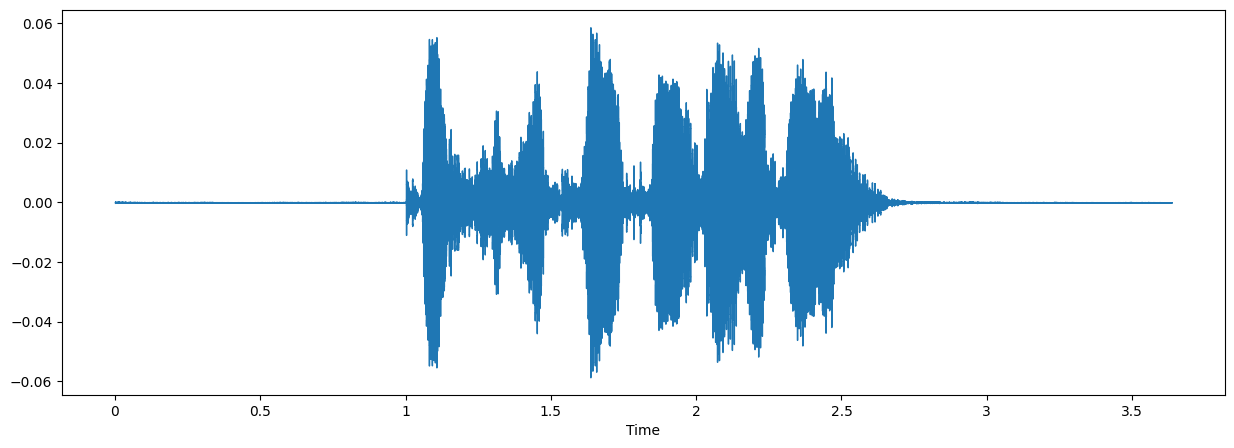

In [9]:
import os
import pandas as pd
import librosa
import glob
import matplotlib.pyplot as plt  # Importa matplotlib para visualización

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

C:\Users\bianc\AppData\Local\Temp\ipykernel_17708\555328279.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read('Audios/Actor_01/03-01-06-01-01-02-01.wav')


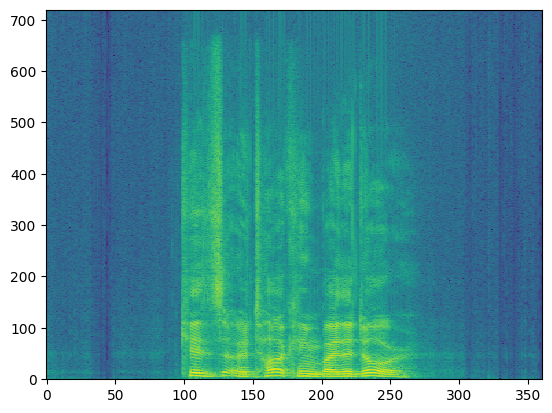

In [10]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('Audios/Actor_01/03-01-06-01-01-02-01.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [11]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [12]:
labels = pd.DataFrame(feeling_list)

In [13]:
labels[:10]

,0
0,male_calm
1,male_calm
2,male_calm
3,male_calm
4,male_calm
5,male_calm
6,male_calm
7,male_calm
8,male_happy
9,male_happy


## Getting the features of audio files using librosa

In [14]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('Audios/Actor_01/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [15]:
df[:5]

,feature
0,"[-70.26808, -70.26808, -70.26808, -70.26808, -..."
1,"[-67.55767, -67.55767, -67.55767, -67.55767, -..."
2,"[-69.69336, -69.69336, -69.69336, -69.69336, -..."
3,"[-69.051476, -69.051476, -69.051476, -69.05147..."
4,"[-73.84186, -73.84186, -73.84186, -73.72008, -..."


In [16]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [17]:
newdf = pd.concat([df3,labels], axis=1)

In [18]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [19]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-57.447964,-58.897030,-58.751503,-57.406185,-60.078960,-63.427284,-62.639057,-61.242519,-61.356304,male_calm
1,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-65.240265,-65.536674,-67.557671,-67.557671,...,-57.271214,-56.744106,-56.141361,-57.532471,-59.493530,-67.150169,-67.499031,-66.098358,-66.741074,male_calm
2,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.620888,-69.693359,-68.906807,...,-61.018982,-60.341557,-63.465752,-64.500572,-61.647270,-58.001892,-58.848892,-62.756329,-62.829971,male_calm
3,-69.051476,-69.051476,-69.051476,-69.051476,-69.051476,-68.755074,-69.051476,-69.051476,-69.051476,-68.359322,...,-57.682072,-56.301693,-58.650570,-63.881496,-63.749794,-65.222809,-65.308594,-67.015755,-68.824036,male_calm
4,-73.841858,-73.841858,-73.841858,-73.720078,-73.841858,-73.841858,-73.841858,-73.304192,-72.807358,-73.841858,...,-50.570274,-53.508461,-54.224915,-51.547527,-52.576477,-54.788902,-56.346535,-57.488159,-57.013565,male_calm


In [20]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
13,-56.755737,-56.760857,-56.415302,-55.715702,-55.817917,-55.832840,-55.889652,-55.116657,-54.244915,-56.211948,...,-39.932247,-43.064877,-46.631870,-48.998745,-46.068245,-45.294624,-47.657749,-51.417549,-54.692829,male_happy
27,-53.997673,-53.863445,-53.553146,-53.879723,-54.017693,-54.071114,-54.129105,-54.258438,-54.263035,-54.137722,...,-41.417324,-41.198059,-45.481594,-47.965866,-49.700962,-52.674263,-52.025494,-51.082546,-52.777302,male_angry
16,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564,-62.797642,-65.721535,-66.348564,-66.348564,-66.348564,...,-52.630859,-49.383850,-49.429741,-52.420185,-53.661373,-53.483269,-52.205978,-53.969204,-55.890995,male_sad
37,-44.640320,-44.249107,-43.996147,-44.132103,-44.267784,-44.346008,-44.142799,-44.255032,-43.666389,-43.591404,...,-33.477657,-33.367554,-32.960381,-31.951487,-31.074728,-31.176338,-30.759199,-22.924541,-15.743834,male_fearful
6,-73.255318,-73.255318,-73.255318,-73.255318,-68.774933,-69.380905,-73.255318,-73.255318,-73.255318,-73.255318,...,-26.482828,-27.126284,-28.192705,-27.185720,-27.307598,-27.423714,-26.709644,-24.996641,-23.706852,male_calm
18,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,...,-70.229752,-70.229752,-70.229752,-70.229752,-66.133965,-62.637821,-66.394821,-70.229752,-70.229752,male_sad
4,-73.841858,-73.841858,-73.841858,-73.720078,-73.841858,-73.841858,-73.841858,-73.304192,-72.807358,-73.841858,...,-50.570274,-53.508461,-54.224915,-51.547527,-52.576477,-54.788902,-56.346535,-57.488159,-57.013565,male_calm
24,-55.932114,-55.772842,-55.716839,-55.835930,-55.932114,-55.932114,-55.932114,-55.932114,-55.932114,-55.932114,...,-42.141296,-42.019539,-41.471268,-42.716209,-45.725437,-47.005997,-48.263088,-51.889610,-53.693489,male_angry
39,-32.140598,-34.252365,-38.971413,-38.443699,-37.651573,-38.045456,-38.625210,-42.541420,-43.463486,-43.102806,...,-29.332127,-27.650616,-31.415056,-34.811867,-34.607533,-35.441376,-35.538944,-36.516891,-36.601814,male_fearful
29,-43.212883,-42.336555,-44.168678,-43.173862,-43.591530,-42.570889,-43.202141,-43.710686,-43.444176,-43.015842,...,-22.873741,-20.374416,-17.856462,-16.366426,-14.621313,-18.455235,-21.158491,-13.505087,-8.131514,male_angry


In [21]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [22]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [23]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0


In [24]:
trainfeatures = train.iloc[:, :-1]

In [25]:
trainlabel = train.iloc[:, -1:]

In [26]:
testfeatures = test.iloc[:, :-1]

In [27]:
testlabel = test.iloc[:, -1:]

In [29]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import numpy as np

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))



c:\Users\bianc\Desktop\SMF\Hack a Boss -  Data Sciences\VirtualEnv\mod3-data-science\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\bianc\Desktop\SMF\Hack a Boss -  Data Sciences\VirtualEnv\mod3-data-science\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
y_train

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [31]:
X_train.shape

(31, 216)

## Changing dimension for CNN model

In [32]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [42]:
num_classes_train = y_train.shape[1]
num_classes_test = y_test.shape[1]
print(f"Número de clases en y_train: {num_classes_train}")
print(f"Número de clases en y_test: {num_classes_test}")

Número de clases en y_train: 5
Número de clases en y_test: 4


In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Activation, Dropout, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()

model.add(Conv1D(256, 5, padding='same', input_shape=(216, 1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=8))
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(4))  # Cambia 10 a 4 si tienes 4 clases
model.add(Activation('softmax'))

# Crear el optimizador RMSprop
opt = RMSprop(learning_rate=0.00001, decay=1e-6)

# Compilar el modelo
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [46]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 216, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 216, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 216, 128)       │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 216, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 216, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 27, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 27, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3456)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │        13,828 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,428 (1.31 MB)

 Trainable params: 343,428 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [48]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

Epoch 1/700


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 5), output.shape=(None, 4)

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [ ]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [ ]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

## Predicting emotions on the test data

In [ ]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

In [ ]:
preds

In [ ]:
preds1=preds.argmax(axis=1)

In [ ]:
preds1

In [ ]:
abc = preds1.astype(int).flatten()

In [ ]:
predictions = (lb.inverse_transform((abc)))

In [ ]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

In [ ]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [ ]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

In [ ]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [ ]:
finaldf[170:180]

In [ ]:
finaldf.groupby('actualvalues').count()

In [ ]:
finaldf.groupby('predictedvalues').count()

In [ ]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [ ]:
data, sampling_rate = librosa.load('output10.wav')

In [ ]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [ ]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output10.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [ ]:
livedf2= pd.DataFrame(data=livedf2)

In [ ]:
livedf2 = livedf2.stack().to_frame().T

In [ ]:
livedf2

In [ ]:
twodim= np.expand_dims(livedf2, axis=2)

In [ ]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

In [ ]:
livepreds

In [ ]:
livepreds1=livepreds.argmax(axis=1)

In [ ]:
liveabc = livepreds1.astype(int).flatten()

In [ ]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions